# PyCUDA_multiplicar_matrices



## Instalación de la librería

In [1]:
!pip install pycuda

## Importando las librerías

In [37]:
# Para inicializar automáticamente PyCUDA y la GPU
import pycuda.autoinit

# Para interactuar directamente con el controlador de la GPU
import pycuda.driver as drv

# Para manipular arrays y operaciones en la CPU
import numpy as np

# Para compilar y cargar módulos CUDA en la GPU
from pycuda.compiler import SourceModule

# Para medir los tiempos
import time

# Para generar gráficos
import matplotlib.pyplot as plt

## Verificación de los recursos de GPU

In [38]:

drv.init()
print("%d dispositivo(s) encontrado." % drv.Device.count())
for i in range(drv.Device.count()):
  dev = drv.Device(i)
  print("\n Dispositivo #%d: %s" % (i, dev.name()))
  print(" Memoria Total: %s GB" % (dev.total_memory() // (1024 * 1024 * 1024)))
  print(" Capacidad de Computación: %d.%d" % dev.compute_capability())

1 dispositivo(s) encontrado.

 Dispositivo #0: NVIDIA GeForce GTX 1070 with Max-Q Design
 Memoria Total: 7 GB
 Capacidad de Computación: 6.1


## Matrices a multiplicar

In [45]:
# Establece la semilla para reproducibilidad
np.random.seed(42)

# Genera dos matrices aleatorias enteras entre 0 y 10 en la CPU (host)
a = np.random.randint(0, 11, size=(128, 128)).astype(np.float32)
b = np.random.randint(0, 11, size=(128, 128)).astype(np.float32)

# Imprime las matrices originales
print("Matriz 'a':")
print(a)
print("\nMatriz 'b':")
print(b)

Matriz 'a':
[[ 6.  3. 10. ...  6.  6. 10.]
 [ 8.  9.  9. ...  0.  1.  0.]
 [ 4.  4. 10. ...  2.  8.  9.]
 ...
 [ 4.  4.  7. ...  9.  5.  6.]
 [ 8.  0.  3. ...  3.  9.  8.]
 [ 3.  3.  6. ...  0.  1.  5.]]

Matriz 'b':
[[ 8.  4.  3. ...  1.  7.  5.]
 [ 6.  0.  5. ...  9.  0.  7.]
 [ 0.  8.  5. ...  5.  0.  1.]
 ...
 [ 0.  1.  3. ...  6.  1.  9.]
 [ 1.  5.  8. ... 10.  1. 10.]
 [ 6.  0.  3. ...  8.  9.  4.]]


## Usando la GPU

In [46]:
def matrix_multiply_gpu_block_size(a, b, block_size=(32, 32, 1)):
    # Verifica si las matrices son compatibles para la multiplicación
    if a.shape[1] != b.shape[0]:
        raise ValueError("Las dimensiones de las matrices no son compatibles para la multiplicación.")

    # Transfiere las matrices a la GPU
    a_gpu = drv.mem_alloc(a.nbytes)
    b_gpu = drv.mem_alloc(b.nbytes)
    drv.memcpy_htod(a_gpu, a)
    drv.memcpy_htod(b_gpu, b)

    # Define un módulo CUDA con un kernel para multiplicar matrices
    mod = SourceModule("""
        __global__ void matrix_multiply(float *result, float *a, float *b, int N, int M, int K)
        {
            int row = threadIdx.y + blockIdx.y * blockDim.y;
            int col = threadIdx.x + blockIdx.x * blockDim.x;
            int idx = row * K + col;

            result[idx] = 0;

            for (int k = 0; k < M; ++k)
                result[idx] += a[row * M + k] * b[k * K + col];
        }
    """)

    # Obtiene el kernel de multiplicación de matrices
    matrix_multiply_kernel = mod.get_function("matrix_multiply")

    # Configura las dimensiones del bloque y de la cuadrícula
    grid_size = (int(np.ceil(a.shape[0] / block_size[0])),
                 int(np.ceil(b.shape[1] / block_size[1])))

    # Crea una matriz en la GPU para almacenar el resultado
    result_gpu = np.zeros((a.shape[0], b.shape[1]), dtype=np.float32)

    # Llama al kernel en la GPU para multiplicar las matrices
    matrix_multiply_kernel(
        drv.Out(result_gpu), a_gpu, b_gpu,
        np.int32(a.shape[0]), np.int32(a.shape[1]), np.int32(b.shape[1]),
        block=block_size, grid=grid_size)

    return result_gpu

# Mide el tiempo de inicio
start_time_gpu = time.time()

# Realiza la multiplicación matricial en la GPU
result_gpu = matrix_multiply_gpu_block_size(a, b, block_size=(32, 32, 1))

# Mide el tiempo de finalización
end_time_gpu = time.time()

# Imprime el resultado de la multiplicación matricial en la GPU
print("\nResultado de la multiplicación matricial en la GPU:")
print(result_gpu)

# Calcula el tiempo transcurrido en la GPU
elapsed_time_gpu = end_time_gpu - start_time_gpu
print(f"\nTiempo transcurrido en la GPU: {elapsed_time_gpu} segundos")


Resultado de la multiplicación matricial en la GPU:
[[2989. 3121. 3238. ... 3319. 3330. 3838.]
 [2875. 2998. 3065. ... 3057. 3073. 3606.]
 [2782. 2790. 3103. ... 3077. 2902. 3281.]
 ...
 [2553. 2664. 2917. ... 2919. 2840. 3026.]
 [2984. 3180. 3385. ... 3315. 3361. 3586.]
 [3057. 2932. 3266. ... 3318. 3434. 3845.]]

Tiempo transcurrido en la GPU: 0.042824506759643555 segundos


## Usando la CPU

In [47]:
def multiply_matrices_with_loops(a, b):
    rows_a, cols_a = a.shape
    rows_b, cols_b = b.shape

    if cols_a != rows_b:
        raise ValueError("Las dimensiones de las matrices no son compatibles para la multiplicación.")

    result = np.zeros((rows_a, cols_b), dtype=np.float32)

    for i in range(rows_a):
        for j in range(cols_b):
            for k in range(cols_a):
                result[i, j] += a[i, k] * b[k, j]

    return result

# Mide el tiempo de inicio
start_time_cpu = time.time()

# Realiza la multiplicación matricial en la CPU con bucles
result_cpu = multiply_matrices_with_loops(a, b)

# Mide el tiempo de finalización
end_time_cpu = time.time()

# Imprime el resultado de la multiplicación matricial en la CPU
print("\nResultado de la multiplicación matricial en la CPU:")
print(result_cpu)

# Calcula el tiempo transcurrido en la CPU
elapsed_time_cpu = end_time_cpu - start_time_cpu
print(f"\nTiempo transcurrido en la CPU: {elapsed_time_cpu} segundos")



Resultado de la multiplicación matricial en la CPU:
[[2989. 3121. 3238. ... 3319. 3330. 3838.]
 [2875. 2998. 3065. ... 3057. 3073. 3606.]
 [2782. 2790. 3103. ... 3077. 2902. 3281.]
 ...
 [2553. 2664. 2917. ... 2919. 2840. 3026.]
 [2984. 3180. 3385. ... 3315. 3361. 3586.]
 [3057. 2932. 3266. ... 3318. 3434. 3845.]]

Tiempo transcurrido en la CPU: 1.2106823921203613 segundos


In [48]:
np.array_equal(result_gpu ,result_cpu)

True

## Comparando los tiempos


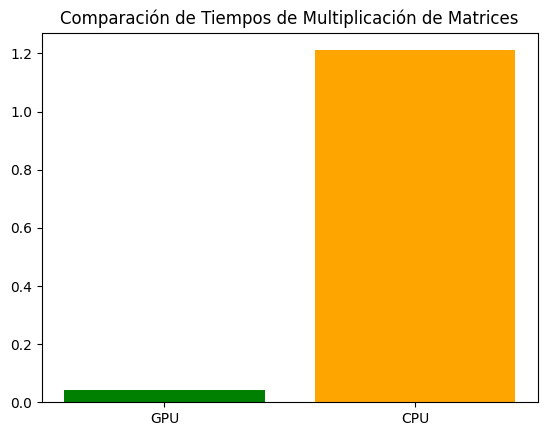

In [49]:
# Nombres de las operaciones
labels = ['GPU', 'CPU']

# Valores de tiempo
values = [elapsed_time_gpu, elapsed_time_cpu]

# Graficar en barras con escala logarítmica en el eje y
plt.bar(labels, values, color=['green', 'orange'])
plt.title('Comparación de Tiempos de Multiplicación de Matrices')
plt.show()


In [50]:
elapsed_time_cpu/elapsed_time_gpu

28.270784271151715